# Autores

- Mario Fernández Simón
- Joan Sales de Marcos

# Predicción de resultados académicos

## 1. Descripción breve del trabajo y sus objetivos

El conjunto de datos escogido para la práctica corresponde a las estadísticas de estudiantes inscritos en diversas Universidades de Portugal. Por lo tanto, cada entrada de nuestro dataset corresponderá a un estudiante en concreto.  
El objetivo será predecir cómo finalizan los estudiantes el curso al final de la carrera y clasificarlos en “dropout”, “enrolled” y “graduate”, es decir, estamos tratando un problema de clasificación.
A priori, nos encontramos con 35 variables y 1 variable objetivo de tipo categórica, la cual transformamos en numérica usando “label encoding”. El siguiente paso realizado será reducir el número de variables eliminando aquellas que no sean importantes o no guarden relación con el objetivo.


In [ ]:
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
from yellowbrick.target.feature_correlation import feature_correlation
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from yellowbrick.target.feature_correlation import feature_correlation
from sklearn.model_selection import GridSearchCV


from sklearn import set_config
import warnings
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))


In [ ]:
# funcion para mostrar resultados
def save_results(clf, X_train, y_train, X_test, y_test, nclf, df):
    df.loc[nclf,'train acc'] = clf.bestscore if hasattr(clf, 'bestscore') else np.mean(cross_val_score(clf, X_train, y_train, cv=10))
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

Source: http://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## 2. Exploración de los datos

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
data = predict_students_dropout_and_academic_success.data.features
target = predict_students_dropout_and_academic_success.data.targets


data.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


In [ ]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Marital Status,4424.0,1.178571,0.605747,1.00,1.00,1.000000,1.000000,6.000000
Application mode,4424.0,18.669078,17.484682,1.00,1.00,17.000000,39.000000,57.000000
Application order,4424.0,1.727848,1.313793,0.00,1.00,1.000000,2.000000,9.000000
Course,4424.0,8856.642631,2063.566416,33.00,9085.00,9238.000000,9556.000000,9991.000000
Daytime/evening attendance,4424.0,0.890823,0.311897,0.00,1.00,1.000000,1.000000,1.000000
Previous qualification,4424.0,4.577758,10.216592,1.00,1.00,1.000000,1.000000,43.000000
Previous qualification (grade),4424.0,132.613314,13.188332,95.00,125.00,133.100000,140.000000,190.000000
Nacionality,4424.0,1.873192,6.914514,1.00,1.00,1.000000,1.000000,109.000000
Mother's qualification,4424.0,19.561935,15.603186,1.00,2.00,19.000000,37.000000,44.000000
Father's qualification,4424.0,22.275316,15.343108,1.00,3.00,19.000000,37.000000,44.000000


Podemos ver en la tabla de debajo que no hay variables que sean identificadores (es decir, que tengan 4424 valores únicos), así que no hay que eliminar variables por este motivo:

In [ ]:
print(data.nunique())

Marital Status                                      6
Application mode                                   18
Application order                                   8
Course                                             17
Daytime/evening attendance                          2
Previous qualification                             17
Previous qualification (grade)                    101
Nacionality                                        21
Mother's qualification                             29
Father's qualification                             34
Mother's occupation                                32
Father's occupation                                46
Admission grade                                   620
Displaced                                           2
Educational special needs                           2
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder          

Hemos decidido eliminar las variables categóricas con muchísimas clases (como ocupación del padre y de la madre, cualificación anterior, etc) para simplificar el problema y también porque consideramos que no es tan relevante para el problema, además de que calcular la importancia de éstas sobre los resultados es prácticamente imposible.

De primeras, hemos decidido eliminar:

- Application mode: por estar mal codificada y no explicar algunos valores
- Course: por tener tantísimos valores de clases y no explicar algunos
- Previous qualification: por tener muchas clases
- Nacionality: porque no nos parece relevante, similar al problema del Titanic
- Qualifications y trabajos del padre y madre: por tener muchísimas clases y no ser relevantes

In [ ]:
data = data.drop(columns=['Application mode', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"])

data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Marital Status,4424.0,1.178571,0.605747,1.00,1.00,1.000000,1.000000,6.000000
Application order,4424.0,1.727848,1.313793,0.00,1.00,1.000000,2.000000,9.000000
Daytime/evening attendance,4424.0,0.890823,0.311897,0.00,1.00,1.000000,1.000000,1.000000
Previous qualification (grade),4424.0,132.613314,13.188332,95.00,125.00,133.100000,140.000000,190.000000
Admission grade,4424.0,126.978119,14.482001,95.00,117.90,126.100000,134.800000,190.000000
Displaced,4424.0,0.548373,0.497711,0.00,0.00,1.000000,1.000000,1.000000
Educational special needs,4424.0,0.011528,0.106760,0.00,0.00,0.000000,0.000000,1.000000
Debtor,4424.0,0.113698,0.317480,0.00,0.00,0.000000,0.000000,1.000000
Tuition fees up to date,4424.0,0.880651,0.324235,0.00,1.00,1.000000,1.000000,1.000000
Gender,4424.0,0.351718,0.477560,0.00,0.00,0.000000,1.000000,1.000000


Pese a que en la web donde se han extraído los datos pone que no hay missing values, lo comprobamos por si acaso.

In [ ]:
data.isna().sum().sort_values(ascending=False)

Marital Status                                    0
Application order                                 0
Inflation rate                                    0
Unemployment rate                                 0
Curricular units 2nd sem (without evaluations)    0
Curricular units 2nd sem (grade)                  0
Curricular units 2nd sem (approved)               0
Curricular units 2nd sem (evaluations)            0
Curricular units 2nd sem (enrolled)               0
Curricular units 2nd sem (credited)               0
Curricular units 1st sem (without evaluations)    0
Curricular units 1st sem (grade)                  0
Curricular units 1st sem (approved)               0
Curricular units 1st sem (evaluations)            0
Curricular units 1st sem (enrolled)               0
Curricular units 1st sem (credited)               0
International                                     0
Age at enrollment                                 0
Scholarship holder                                0
Gender      

De las variables que nos quedan miraremos si son realmente relevantes para el estudio, si están correlacionadas, y si las numéricas siguen una distribución Gausiana o tienen outliers.

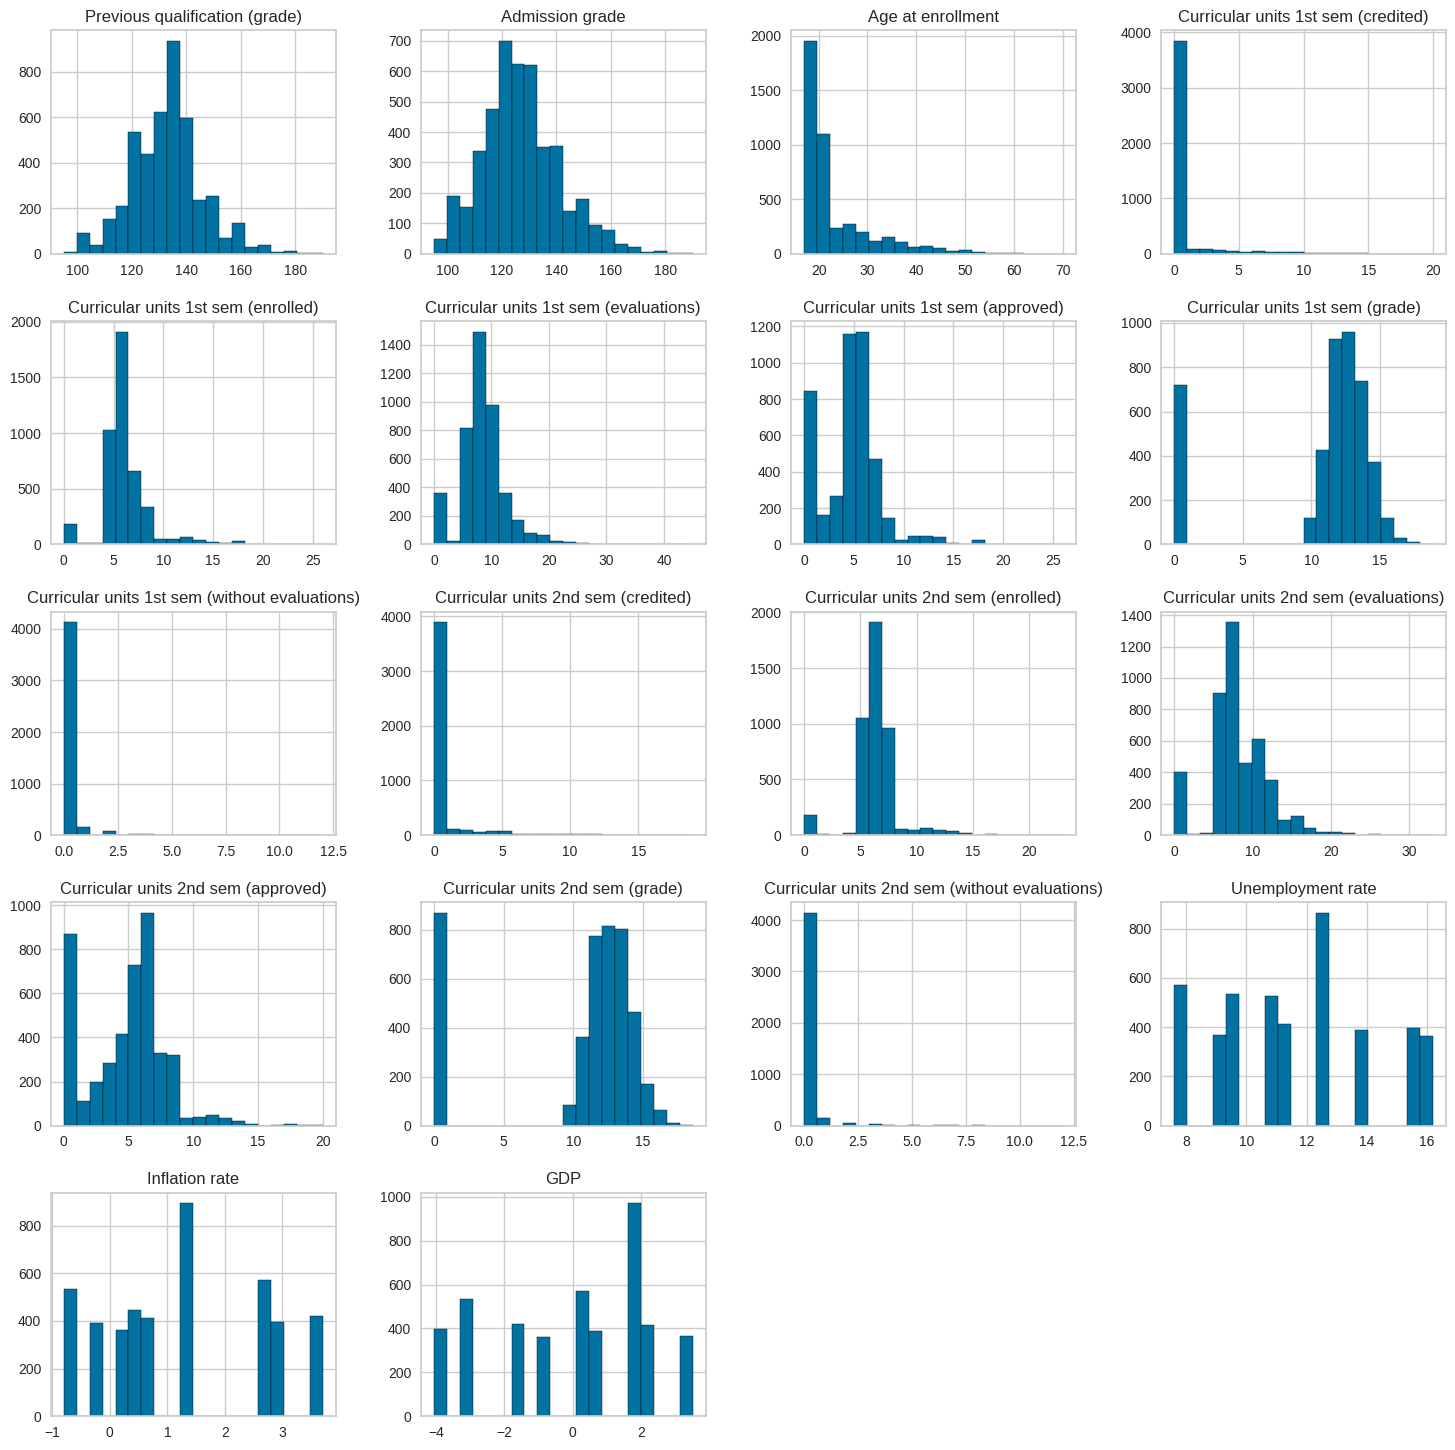

In [ ]:
data.loc[:,['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)',
            'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
            'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)',
            'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
            'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']].hist(bins=20, edgecolor='black', figsize=(18,18));

Se puede apreciar en los gráficos de arriba que las unidades curriculares aprobadas y sin evaluación son casi siempre de cero, por tanto no serán relevantes para el estudio y se pueden eliminar.

También se aprecia que el ratio de desempleo, inflación y GDP no son Gaussianos y que siguen un patrón más bien pseudo-aleatorio, por tanto confiamos en que se pueden eliminar.

In [ ]:
data = data.drop(columns=['Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)'])

data = data.drop(columns=['Unemployment rate', 'Inflation rate', 'GDP'])

data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Marital Status,4424.0,1.178571,0.605747,1.0,1.00,1.000000,1.000000,6.000000
Application order,4424.0,1.727848,1.313793,0.0,1.00,1.000000,2.000000,9.000000
Daytime/evening attendance,4424.0,0.890823,0.311897,0.0,1.00,1.000000,1.000000,1.000000
Previous qualification (grade),4424.0,132.613314,13.188332,95.0,125.00,133.100000,140.000000,190.000000
Admission grade,4424.0,126.978119,14.482001,95.0,117.90,126.100000,134.800000,190.000000
Displaced,4424.0,0.548373,0.497711,0.0,0.00,1.000000,1.000000,1.000000
Educational special needs,4424.0,0.011528,0.106760,0.0,0.00,0.000000,0.000000,1.000000
Debtor,4424.0,0.113698,0.317480,0.0,0.00,0.000000,0.000000,1.000000
Tuition fees up to date,4424.0,0.880651,0.324235,0.0,1.00,1.000000,1.000000,1.000000
Gender,4424.0,0.351718,0.477560,0.0,0.00,0.000000,1.000000,1.000000


Ahora comprobaremos las relaciones entre las variables categóricas:

<Axes: >

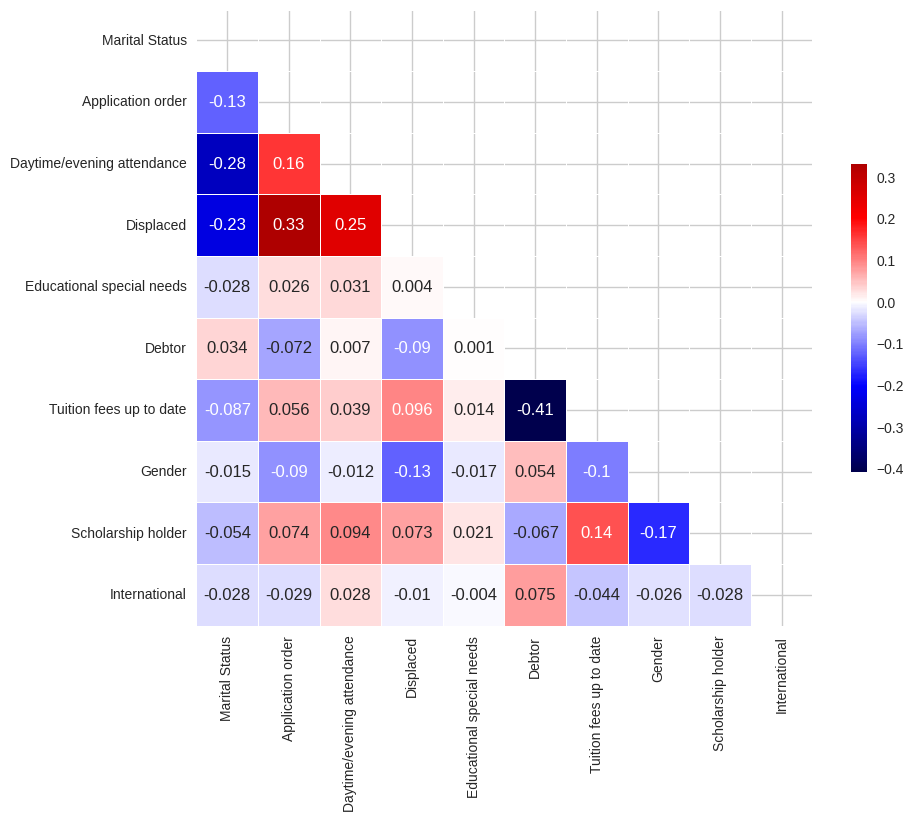

In [ ]:
categorical_vars = ['Marital Status', 'Application order', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder' , 'International']
categorical_data = data[categorical_vars]

corr_categoricals = categorical_data.corr(numeric_only=True).round(3)
mask = np.triu(np.ones_like(corr_categoricals, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_categoricals, mask=mask, annot = True, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

A continuación compararemos la correlación entre todas las variables, ya que pueden haber relaciones ocultas que no hayamos pensado:


<Axes: >

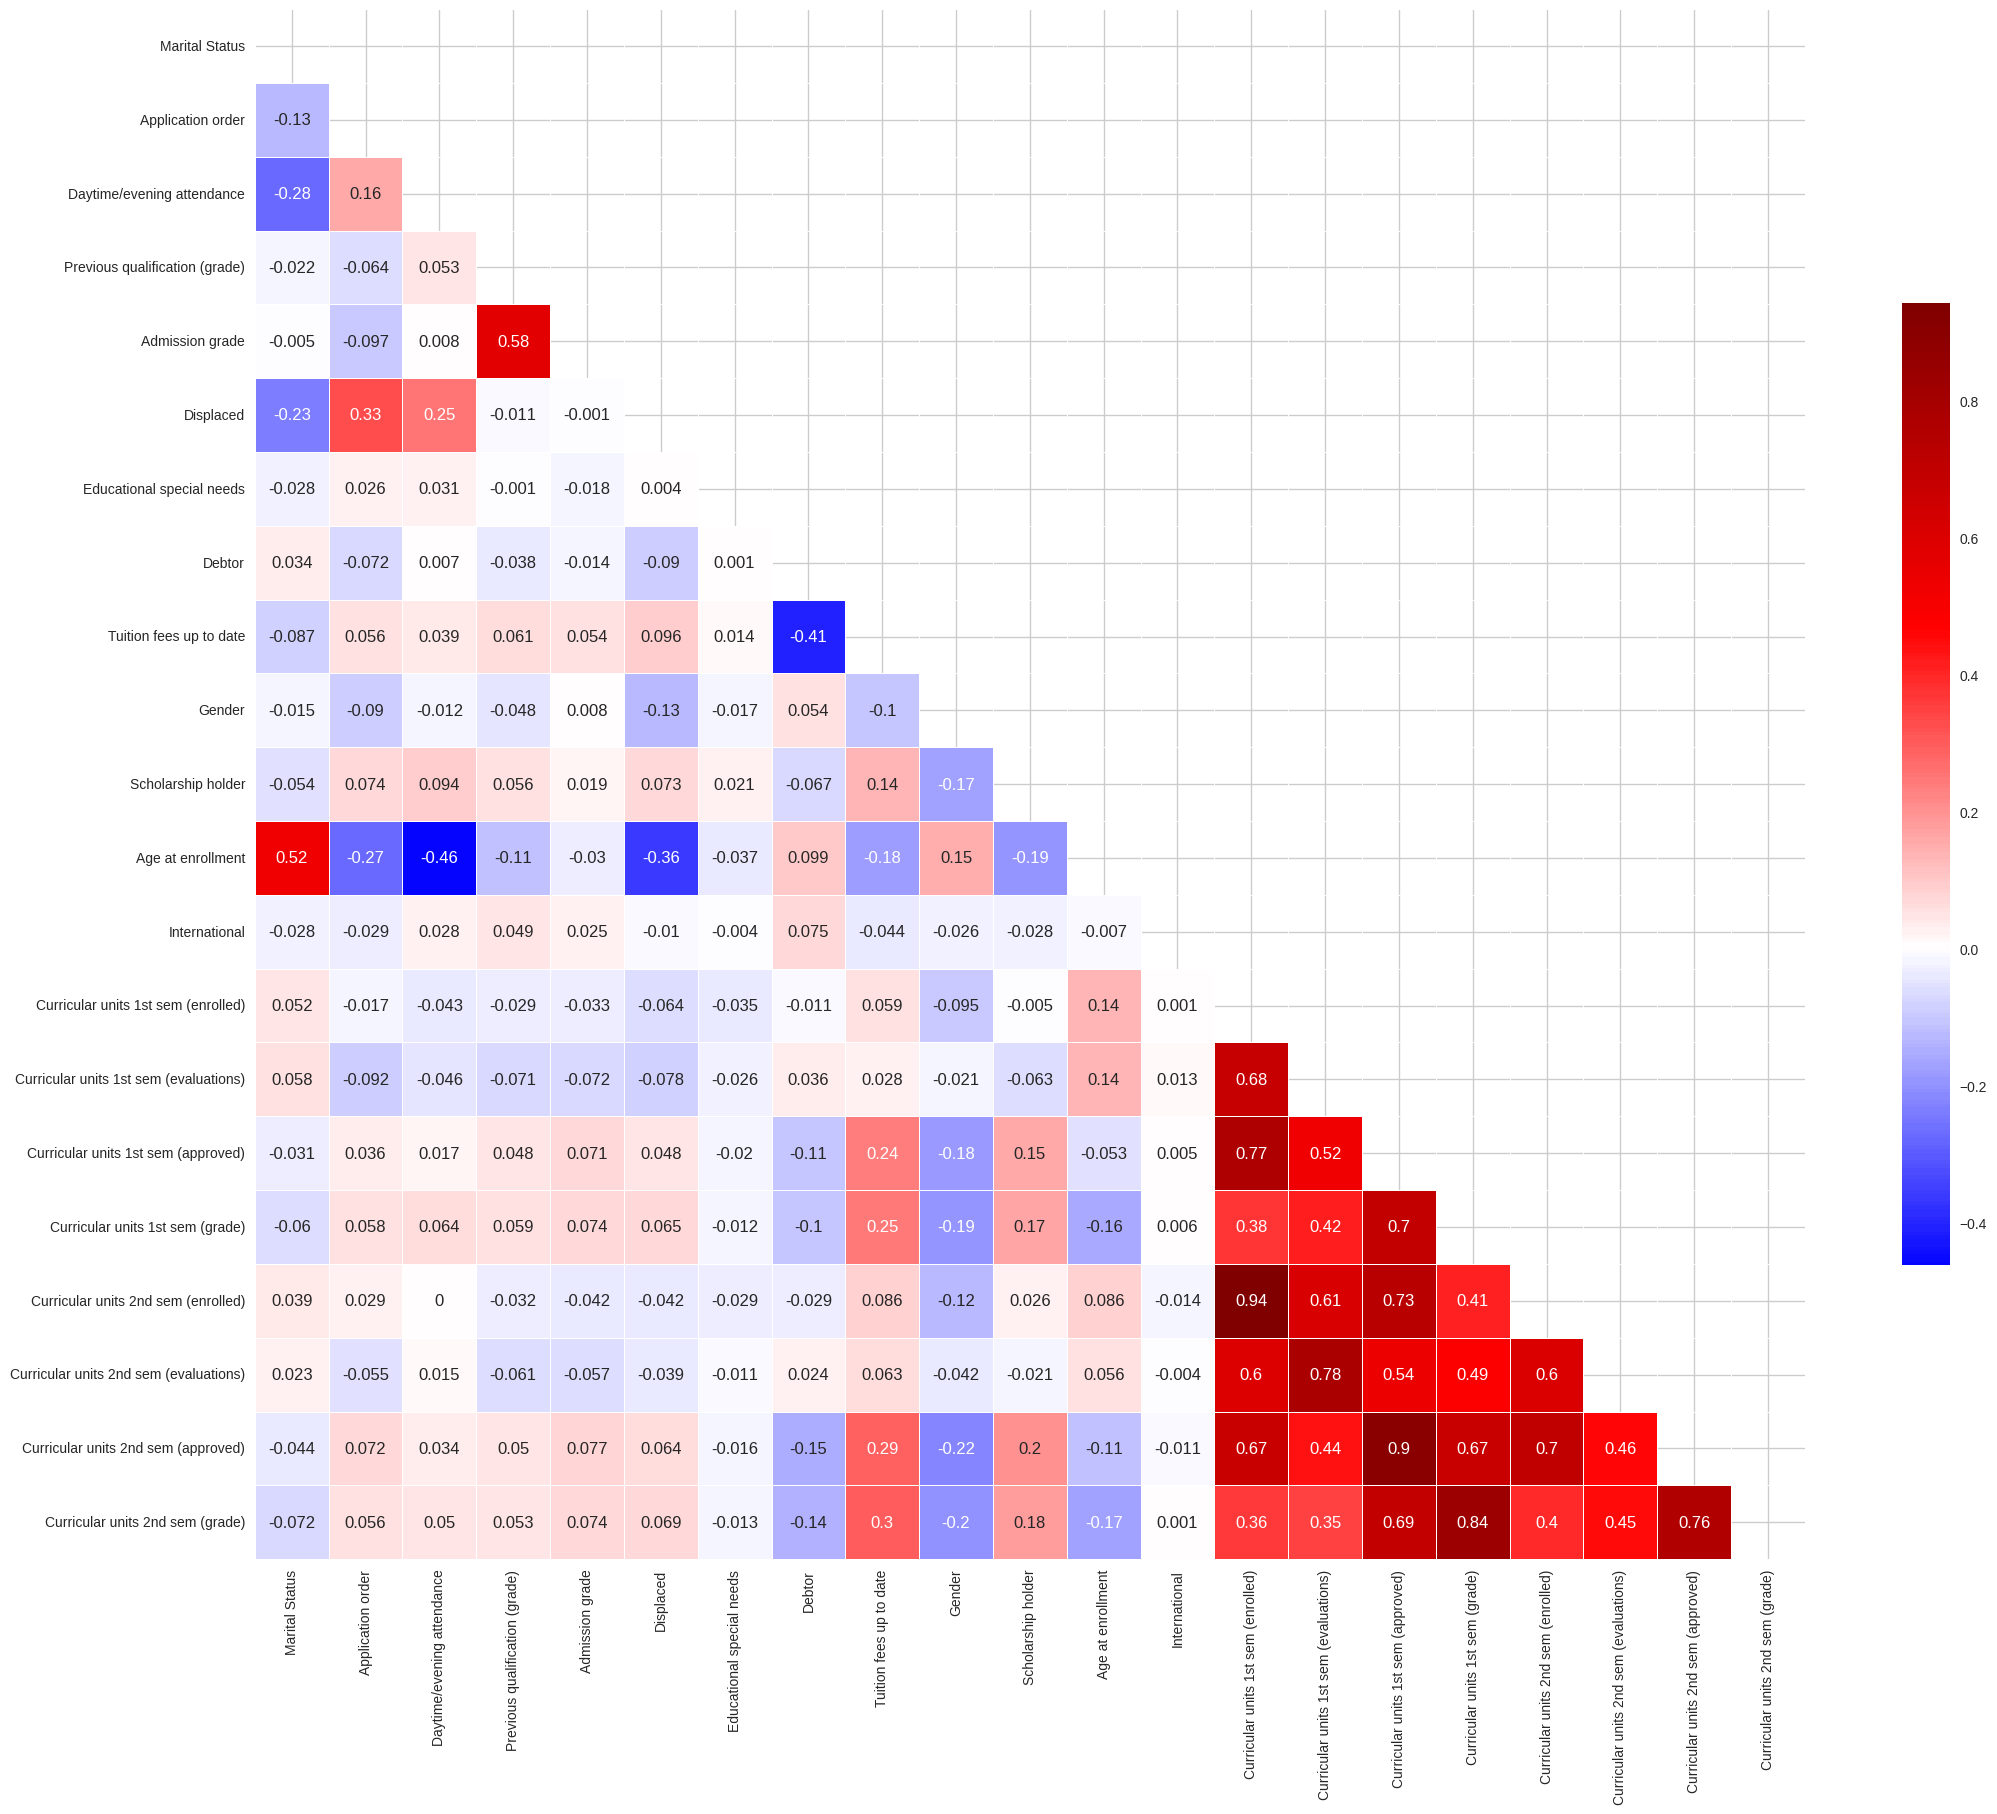

In [ ]:
corr_todas = data.corr(numeric_only=True).round(3)
mask = np.triu(np.ones_like(corr_todas, dtype=bool))
plt.subplots(figsize=(25, 25))
sns.heatmap(corr_todas, mask=mask, annot = True, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Eliminaremos international, debtor, educational especial needs y quizás en un futuro gender.

Además se puede ver trivialmente cómo los créditos matriculados y superados entre los semestres están muy fuertemente relacionados entre ellos, pero no necesariamente con el resto de variables, lo cuál es interesante.

In [ ]:
data = data.drop(columns=['International', 'Debtor', 'Educational special needs'])

data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Marital Status,4424.0,1.178571,0.605747,1.0,1.00,1.000000,1.000000,6.000000
Application order,4424.0,1.727848,1.313793,0.0,1.00,1.000000,2.000000,9.000000
Daytime/evening attendance,4424.0,0.890823,0.311897,0.0,1.00,1.000000,1.000000,1.000000
Previous qualification (grade),4424.0,132.613314,13.188332,95.0,125.00,133.100000,140.000000,190.000000
Admission grade,4424.0,126.978119,14.482001,95.0,117.90,126.100000,134.800000,190.000000
Displaced,4424.0,0.548373,0.497711,0.0,0.00,1.000000,1.000000,1.000000
Tuition fees up to date,4424.0,0.880651,0.324235,0.0,1.00,1.000000,1.000000,1.000000
Gender,4424.0,0.351718,0.477560,0.0,0.00,0.000000,1.000000,1.000000
Scholarship holder,4424.0,0.248418,0.432144,0.0,0.00,0.000000,0.000000,1.000000
Age at enrollment,4424.0,23.265145,7.587816,17.0,19.00,20.000000,25.000000,70.000000


Otro aspecto que revisamos es la existencia de valores extremos muy alejados de la media. Rápidamente, se observa como no hay ningún valor que se aleje de manera exagerada de la media y, por tanto, no hay que hacer ningún ajuste extra.


Comparando todas las variables con la objetivo, tenemos que:

In [ ]:
# 1: Graduate, 2: Enrolled, 3: Dropout
target_nums = target['Target'].replace({'Graduate': 2, 'Enrolled': 1, 'Dropout': 0})

data_n_target = pd.concat([data,target_nums], axis=1)

data_n_target.head()

,Marital Status,Application order,Daytime/evening attendance,Previous qualification (grade),Admission grade,Displaced,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Target
0,1,5,1,122.0,127.3,1,1,1,0,20,0,0,0,0.000000,0,0,0,0.000000,0
1,1,1,1,160.0,142.5,1,0,1,0,19,6,6,6,14.000000,6,6,6,13.666667,2
2,1,5,1,122.0,124.8,1,0,1,0,19,6,0,0,0.000000,6,0,0,0.000000,0
3,1,2,1,122.0,119.6,1,1,0,0,20,6,8,6,13.428571,6,10,5,12.400000,2
4,2,1,0,100.0,141.5,0,1,0,0,45,6,9,5,12.333333,6,6,6,13.000000,2


<Axes: >

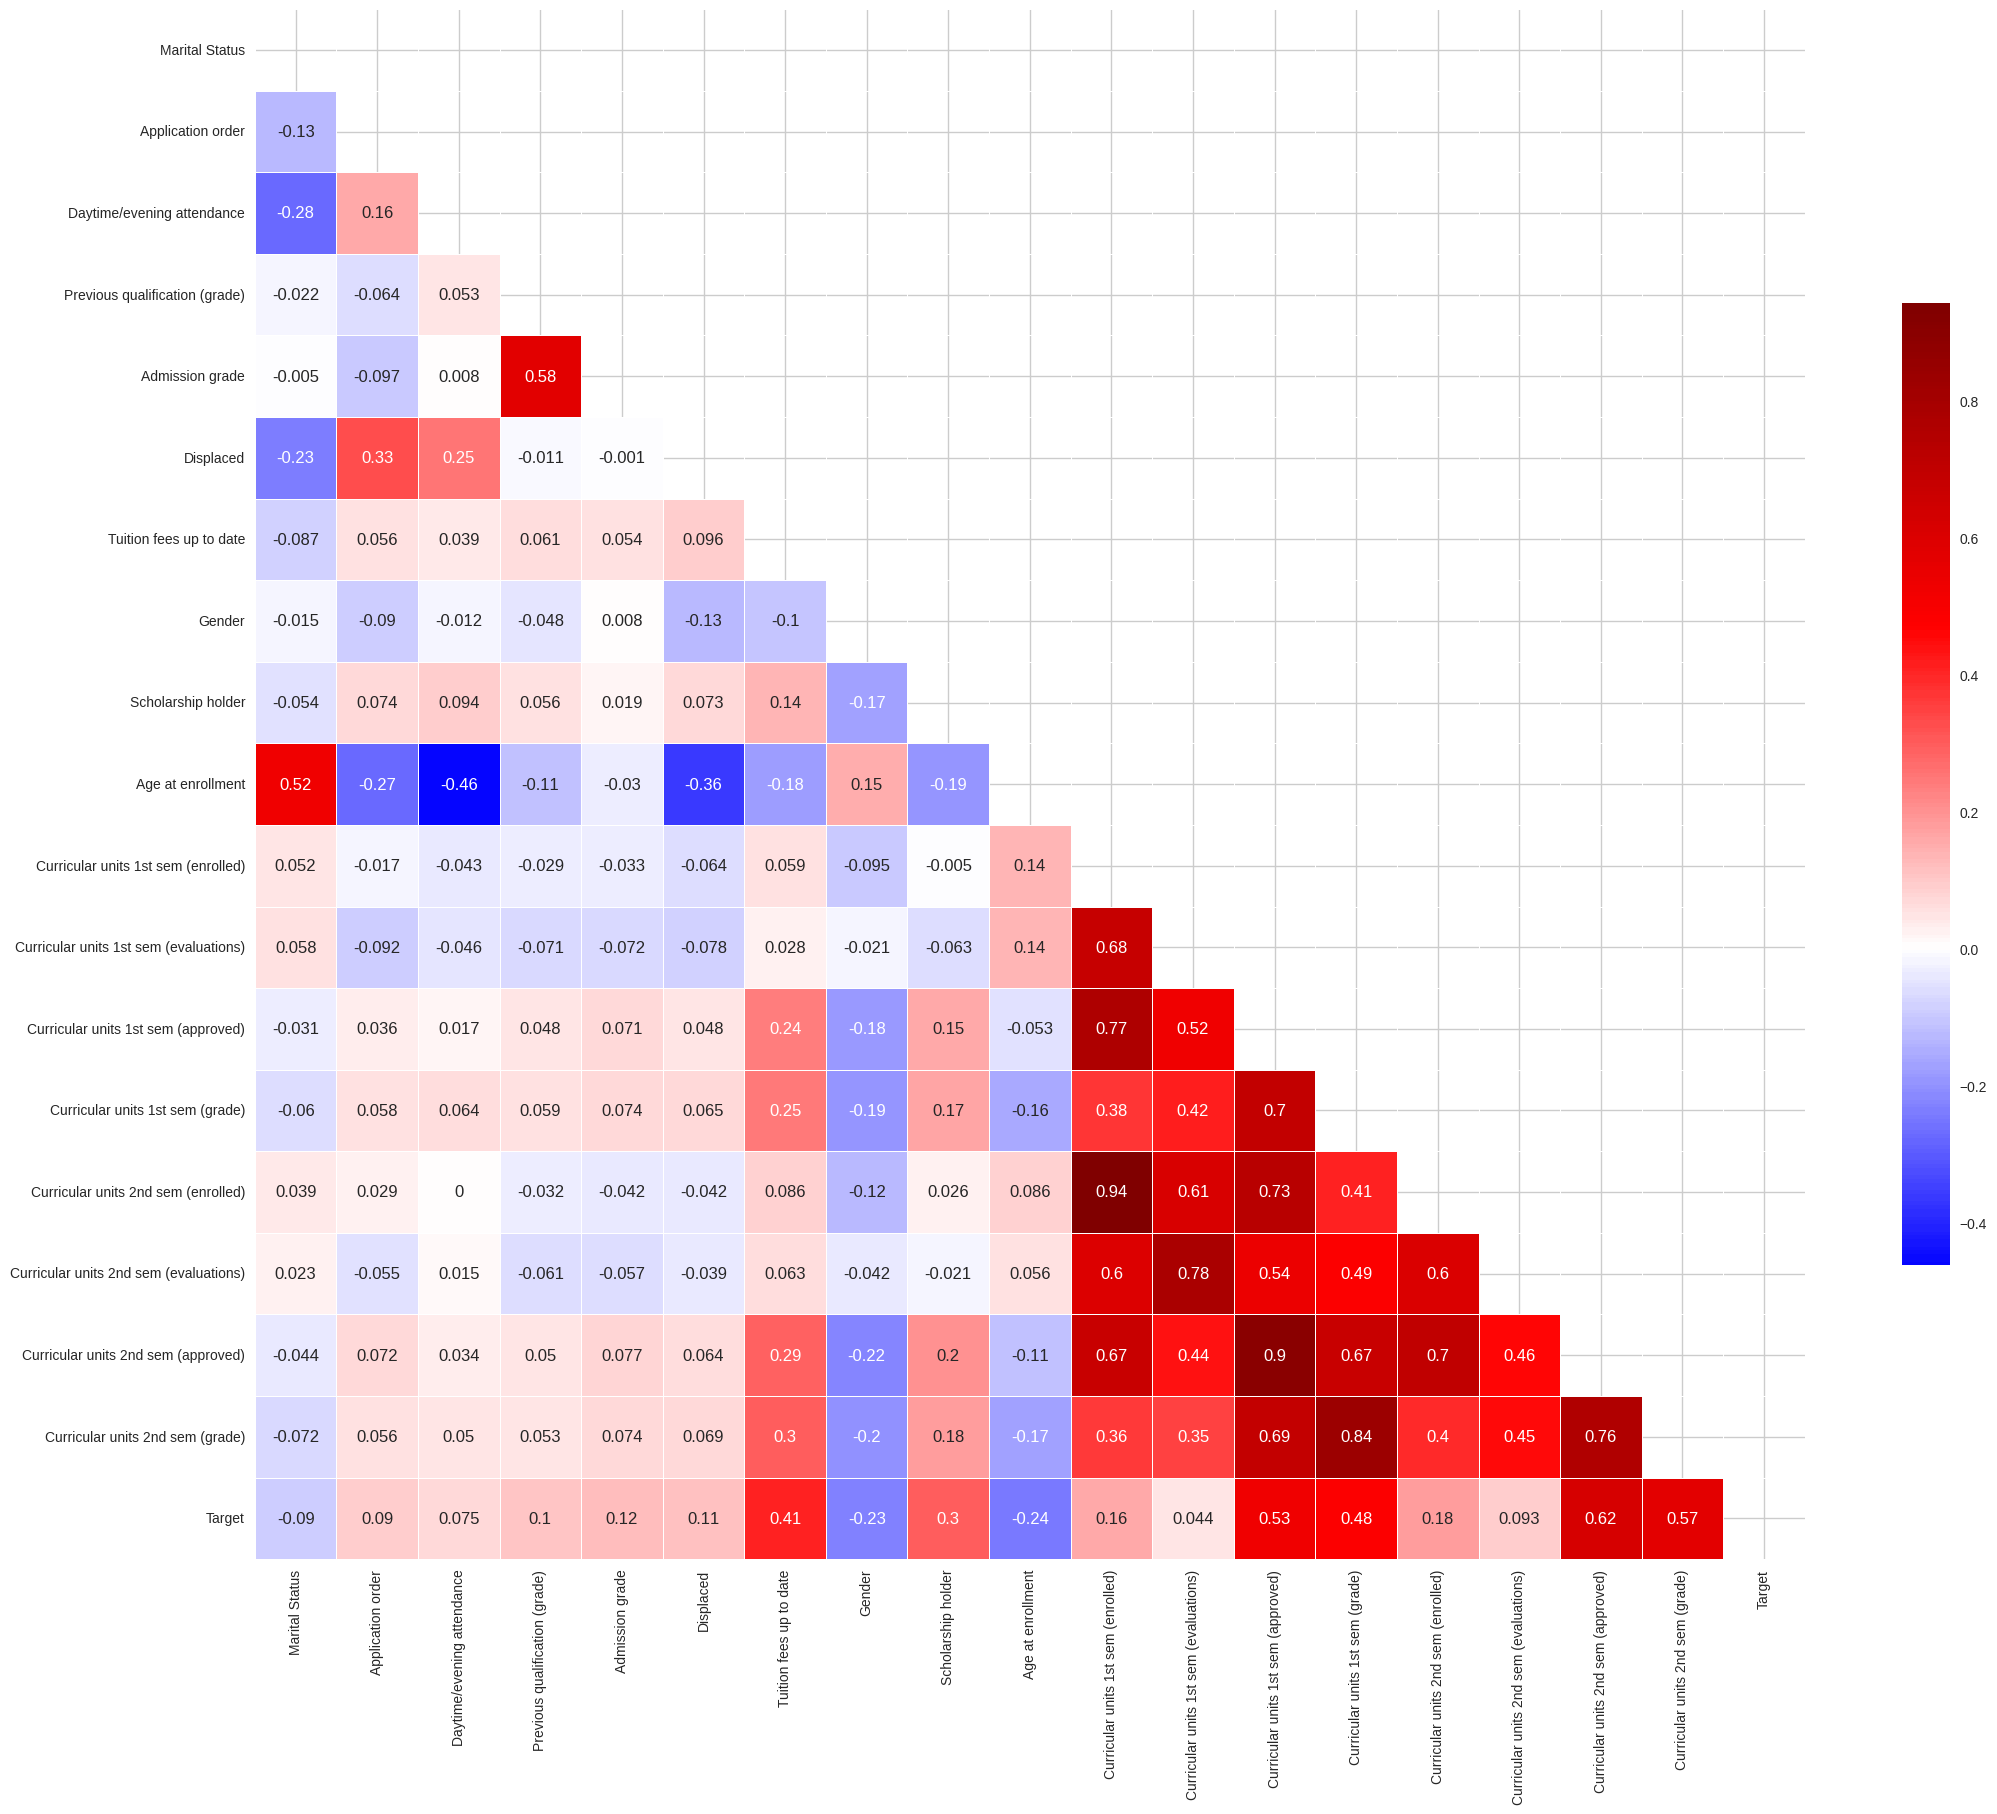

In [ ]:
corr_todas = data_n_target.corr(numeric_only=True).round(3)
mask = np.triu(np.ones_like(corr_todas, dtype=bool))
plt.subplots(figsize=(25, 25))
sns.heatmap(corr_todas, mask=mask, annot = True, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

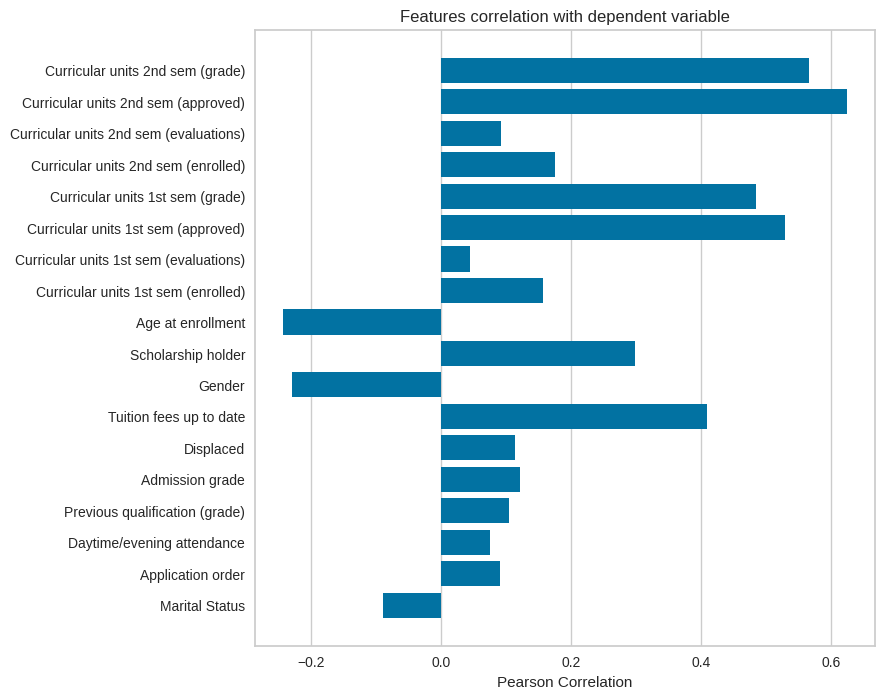

In [ ]:
plt.figure(figsize=(8, 8))
corre = feature_correlation(data, target_nums, labels=list(data.columns),method='pearson')

Aplicaremos un PCA a los datos estandarizados

In [ ]:
# Separamos datos de entreno y test
VarTrain, VarTest, yTrain, yTest = train_test_split(data, target_nums, test_size=0.2, random_state=0)

# Estandarizamos
scaler = StandardScaler()
VarsTrainSTD = scaler.fit_transform(VarTrain)
VarsTestSTD = scaler.transform(VarTest)

In [ ]:
from sklearn.decomposition import PCA

# PCA
myPCA = PCA().fit(VarsTrainSTD)

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.29683903 0.14655686 0.09425678 0.07226746 0.05750248 0.05088468
 0.04563153 0.04462383 0.04060282 0.03661392 0.03437134 0.0221792
 0.01972247 0.01213322 0.01093403 0.00905147 0.00440231 0.00142657]
[0.29683903 0.4433959  0.53765268 0.60992014 0.66742262 0.7183073
 0.76393883 0.80856265 0.84916547 0.88577939 0.92015073 0.94232993
 0.9620524  0.97418562 0.98511966 0.99417112 0.99857343 1.        ]


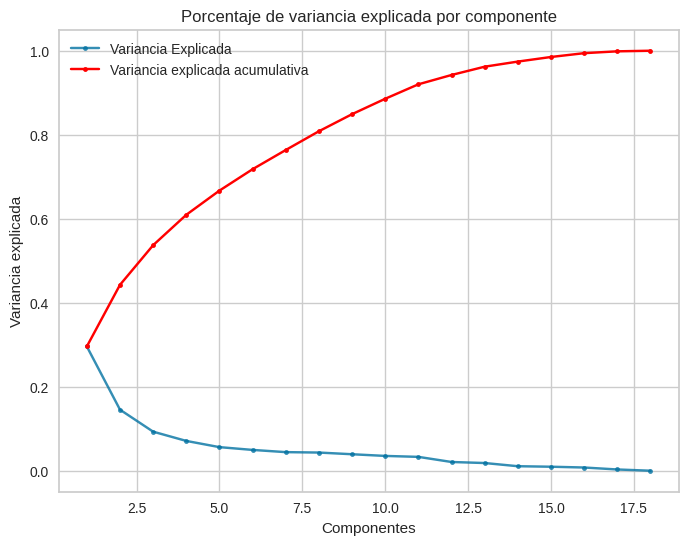

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

En este gráfica podemos ver como afecta el ir añadiendo componentes. Se observa que sin contar el primer componente no hay componentes que acumulen por si solo mucha varianza. Llegamos al 80% de varianza acumulada con 8 componentes y necesitamos unas 15 para llegar al 100%.


Al finalizar la limpieza de las variables nos hemos quedado con las siguientes:
- Marital Status: Estado legal matrimonial (entre 9 opciones)
- Application order: orden de aplicación (entre 0-primera opción; y 9-última opción).
- Daytime/evening attendance: 1 si va de mañanas y 0 si va por la tarde.
- Previous qualification (grade): estudios cursados anteriormente.
- Admission grade: nota de admisión (entre 0 y 200).
- Displaced: 1 si se ha mudado para ir a la universidad o 0 por el contrario.
- Tuition fees up to date: 1 si lleva las facturas al día o 0 por el contrario.
- Gender: 1-macho y 0-hembra.
- Scholarship holder: 1 dispone de beca o 0 por el contrario.
- Age at enrollment: edad al inscribirse en el curso.
- Curricular units 1st/2nd sem (enrolled): créditos cursados.
- Curricular units 1st/2nd sem (evaluations): créditos evaluados.
- Curricular units 1st/2nd sem (approved): créditos aprobados.
- Curricular units 1st/2nd sem (grade): nota obtenida.


## 3. Métodos Lineales




### Naive Bayes

Hacemos Naive Bayes para hacernos una idea de la veracidad y certeza de las predicciones:

In [ ]:
gnb = GaussianNB()
print(f'Cross Validation:' ,np.mean(cross_val_score(gnb,VarsTrainSTD,yTrain,cv=10)))

gnb_model = GaussianNB().fit(VarsTrainSTD, yTrain)
print(classification_report(gnb_model.predict(VarsTestSTD), yTest,target_names=['dropout', 'enrolled', 'graduate']))

results_df = save_results(gnb_model, VarsTrainSTD, yTrain, VarsTestSTD, yTest, 'Naive Bayes', results_df)

Cross Validation: 0.7179886685552409
              precision    recall  f1-score   support

     dropout       0.68      0.73      0.71       266
    enrolled       0.35      0.48      0.41       110
    graduate       0.88      0.78      0.83       509

    accuracy                           0.73       885
   macro avg       0.64      0.66      0.65       885
weighted avg       0.76      0.73      0.74       885



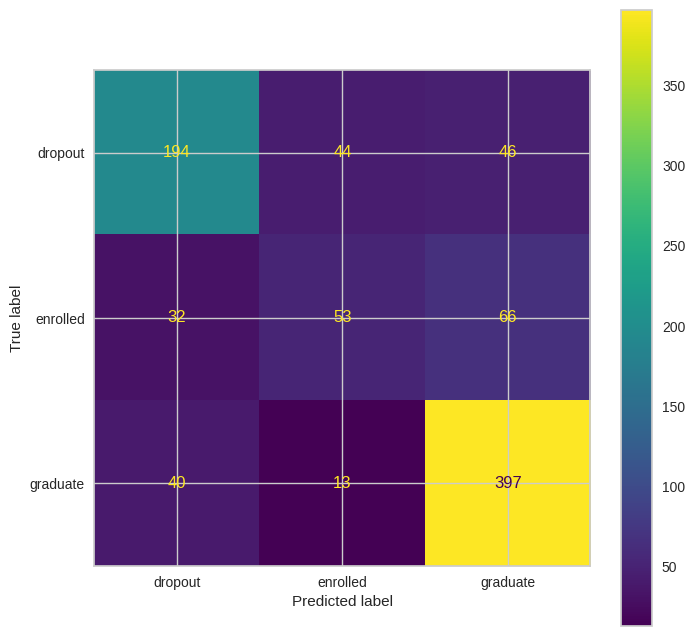

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(gnb_model, VarsTestSTD,yTest, display_labels=['dropout', 'enrolled', 'graduate'], ax=plt.subplot())

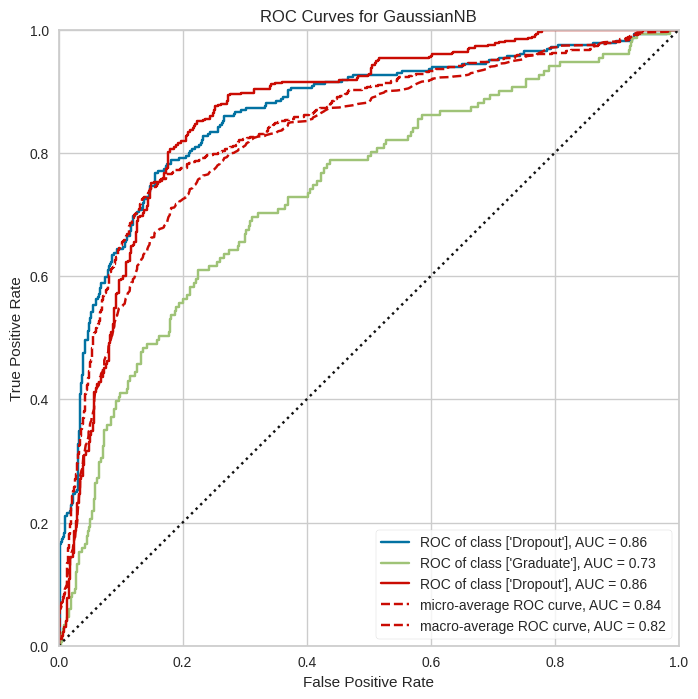

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=        Target
0      Dropout
1     Graduate
2      Dropout
3     Graduate
4     Graduate
...        ...
4419  Graduate
4420   Dropout
4421   Dropout
4422  Graduate
4423  Graduate

[4424 rows x 1 columns],
       estimator=GaussianNB())

In [ ]:
plt.figure(figsize=(8,8))
roc_auc(gnb_model, VarsTestSTD,yTest, classes=target)

### Regresión Logísitica

Hacemos una regresión logística sencilla para hacernos una idea de la veracidad y certeza de las predicciones:

In [ ]:
# Regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logisticReg = LogisticRegression(max_iter=1000)
print(np.mean(cross_val_score(logisticReg,VarsTrainSTD,yTrain,cv=10)))

0.7584057553496263


In [ ]:
param = {'penalty':['l2', 'none'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(logisticReg,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(VarsTrainSTD, yTrain);

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [ ]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())


,params,mean_test_score,rank_test_score
41,"{'C': 1000.0, 'penalty': 'none'}",0.758971,1
27,"{'C': 7.943282347242813, 'penalty': 'none'}",0.758971,1
25,"{'C': 3.981071705534969, 'penalty': 'none'}",0.758971,1
24,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.758971,1
23,"{'C': 1.9952623149688788, 'penalty': 'none'}",0.758971,1


Coefs:


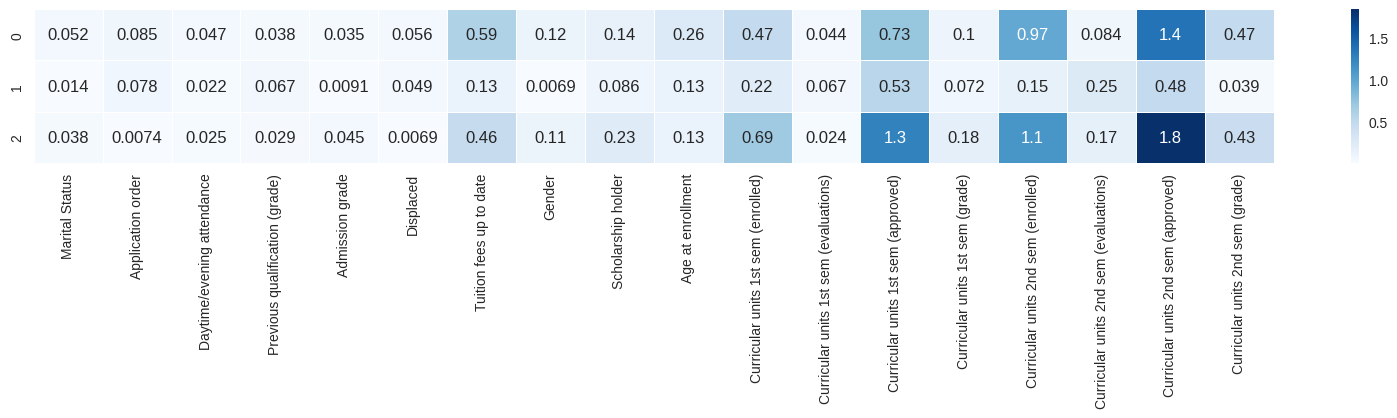

In [ ]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = data.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

In [ ]:
print(classification_report(lr_gs.predict(VarsTestSTD), yTest,target_names=['dropout', 'enrolled', 'graduate']))
results_df = save_results(lr_gs, VarsTrainSTD, yTrain, VarsTestSTD, yTest, 'Logistic Regression', results_df);

              precision    recall  f1-score   support

     dropout       0.74      0.80      0.77       263
    enrolled       0.38      0.53      0.44       107
    graduate       0.93      0.82      0.87       515

    accuracy                           0.78       885
   macro avg       0.68      0.72      0.69       885
weighted avg       0.81      0.78      0.79       885



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


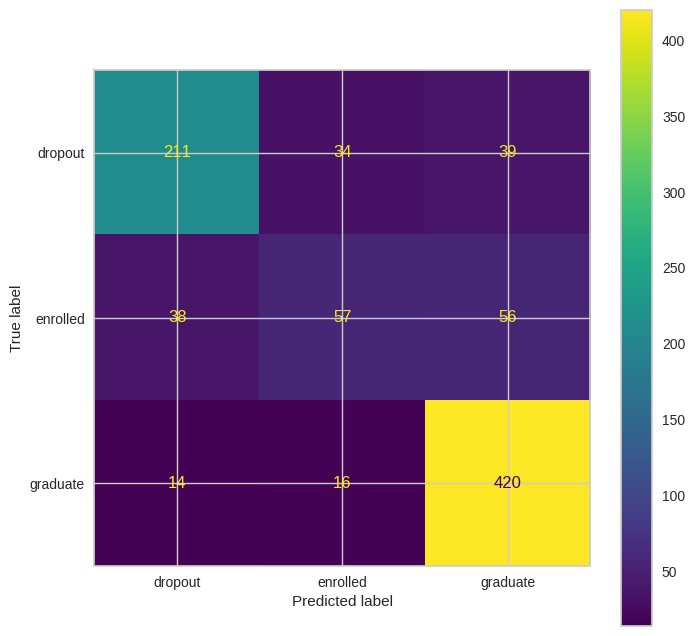

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lr_gs, VarsTestSTD,yTest, display_labels=['dropout', 'enrolled', 'graduate'], ax=plt.subplot())

Se observa en la matriz de confusión que las dudas y problemas principales del modelo generalmente están en la predicción de enrolled, con una precisión del ~35% y recall de ~50%. Aún así, la regresión logística ha dado un resultado de predicción aceptable con 0.77.

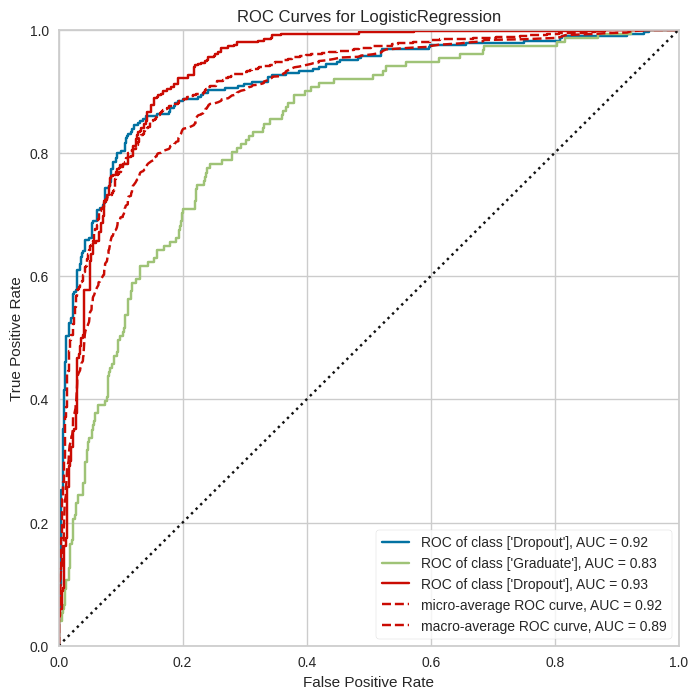

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=        Target
0      Dropout
1     Graduate
2      Dropout
3     Graduate
4     Graduate
...        ...
4419  Graduate
4420   Dropout
4421   Dropout
4422  Graduate
4423  Graduate

[4424 rows x 1 columns],
       estimator=LogisticRegression(max_iter=1000))

In [ ]:
plt.figure(figsize=(8,8))
roc_auc(logisticReg, VarsTestSTD,yTest, classes=target)

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
print(np.mean(cross_val_score(lda,VarsTrainSTD,yTrain,cv=10)))

0.7499247771322481


Coefs:


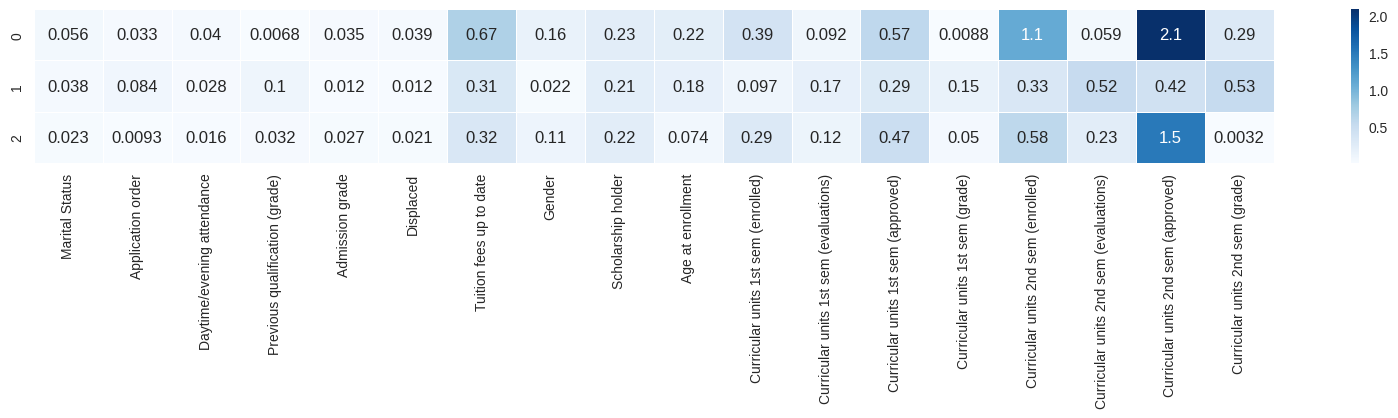

In [ ]:
lda_model = LinearDiscriminantAnalysis().fit(VarsTrainSTD, yTrain)

print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = data.columns
# coefs.T

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

In [ ]:
print(classification_report(lda_model.predict(VarsTestSTD), yTest, target_names=['dropout', 'enrolled', 'graduate']))
results_df = save_results(lda_model, VarsTrainSTD, yTrain, VarsTestSTD, yTest, 'LDA', results_df)

              precision    recall  f1-score   support

     dropout       0.67      0.87      0.75       218
    enrolled       0.40      0.50      0.44       120
    graduate       0.96      0.79      0.86       547

    accuracy                           0.77       885
   macro avg       0.67      0.72      0.69       885
weighted avg       0.81      0.77      0.78       885



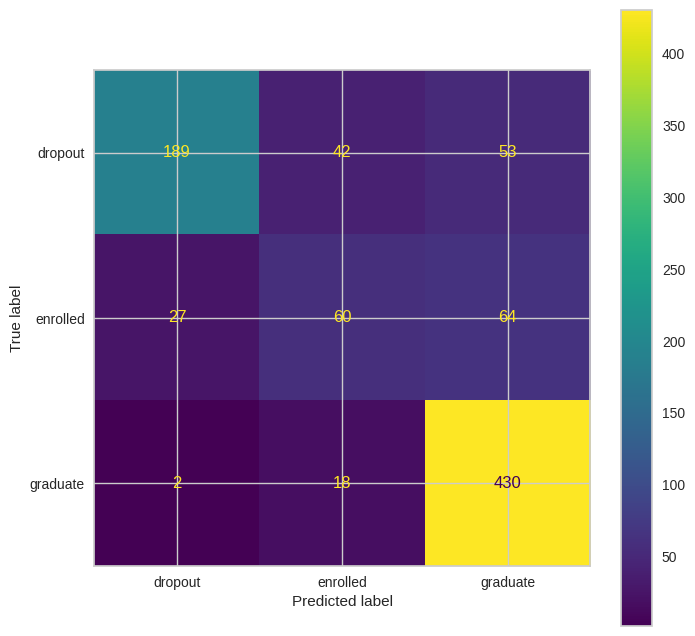

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lda_model, VarsTestSTD,yTest, display_labels=['dropout', 'enrolled', 'graduate'], ax=plt.subplot())

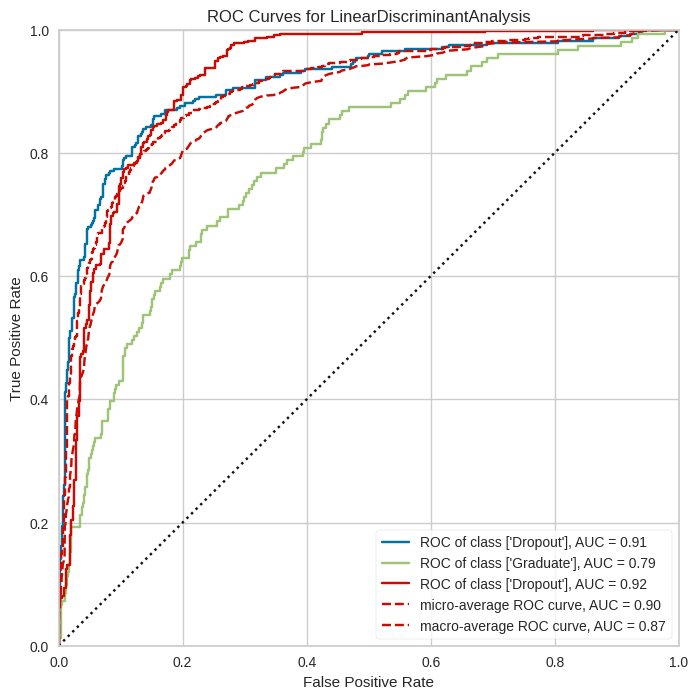

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for LinearDiscriminantAnalysis'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=        Target
0      Dropout
1     Graduate
2      Dropout
3     Graduate
4     Graduate
...        ...
4419  Graduate
4420   Dropout
4421   Dropout
4422  Graduate
4423  Graduate

[4424 rows x 1 columns],
       estimator=LinearDiscriminantAnalysis())

In [ ]:
plt.figure(figsize=(8,8))
roc_auc(lda_model, VarsTestSTD,yTest, classes=target)

## 4. Métodos no Lineales

### Random Forest

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Parámetros para Random Forest
params = {'n_estimators': [10, 200],
         'criterion':['gini', 'entropy'],
         'max_depth':[None, 1, 20],
         'min_samples_split': [2, 20],
         'min_samples_leaf':[1, 20]}

# Ajustamos el modelo con Búsqueda Bayesiana
model_RF = RandomForestClassifier(random_state=0)
rf_bs = BayesSearchCV(
    model_RF,
    params,
    n_iter = 40,  # Número de iteraciones de la búsqueda bayesiana
    cv = 5,
    n_jobs=-1,
    refit=True,
    random_state=0
)

# ~3 minutos
rf_bs.fit(VarsTrainSTD, yTrain)

# Mejores parámetros encontrados con BayesSearch
print('Mejores hiperparámetros:')
print(rf_bs.best_params_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Mejores hiperparámetros:
OrderedDict([('criterion', 'entropy'), ('max_depth', None), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 130)])


In [ ]:
# ~30 minutos
yPred_rf_bs = rf_bs.predict(VarsTestSTD)
results_df = save_results(rf_bs, VarsTrainSTD, yTrain, VarsTestSTD, yTest, 'Random Forest', results_df)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

In [ ]:
accuracy_rf_bs = accuracy_score(yTest, yPred_rf_bs)
print(f'Precisión del modelo Random Forest con búsqueda bayesiana: {accuracy_rf_bs}')

Precisión del modelo Random Forest con búsqueda bayesiana: 0.7954802259887006


In [ ]:
# Classification Report
class_report_rf_bs = classification_report(yTest, yPred_rf_bs, target_names=['dropout', 'enrolled', 'graduate'])
print('Informe de Clasificación Random Forest con búsqueda bayesiana:')
print(class_report_rf_bs)

Informe de Clasificación Random Forest con búsqueda bayesiana:
              precision    recall  f1-score   support

     dropout       0.83      0.76      0.79       284
    enrolled       0.58      0.44      0.50       151
    graduate       0.83      0.94      0.88       450

    accuracy                           0.80       885
   macro avg       0.75      0.71      0.72       885
weighted avg       0.79      0.80      0.79       885



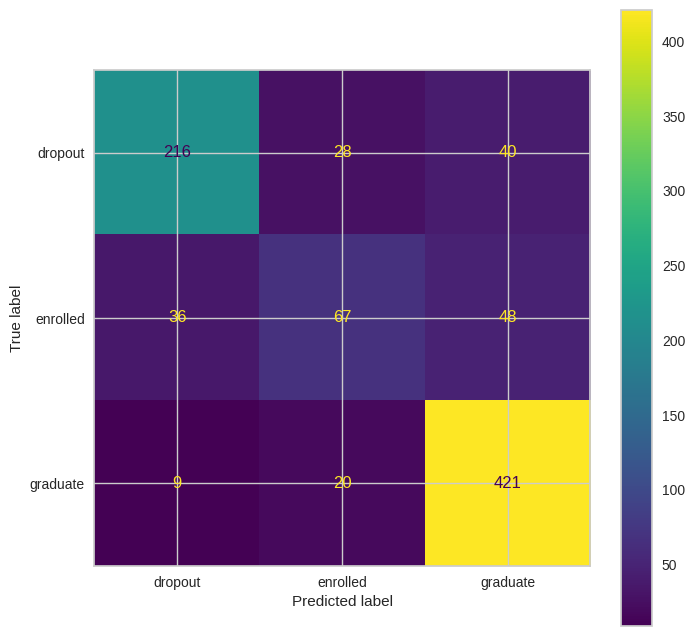

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(rf_bs, VarsTestSTD,yTest, display_labels=['dropout', 'enrolled', 'graduate'], ax=plt.subplot())

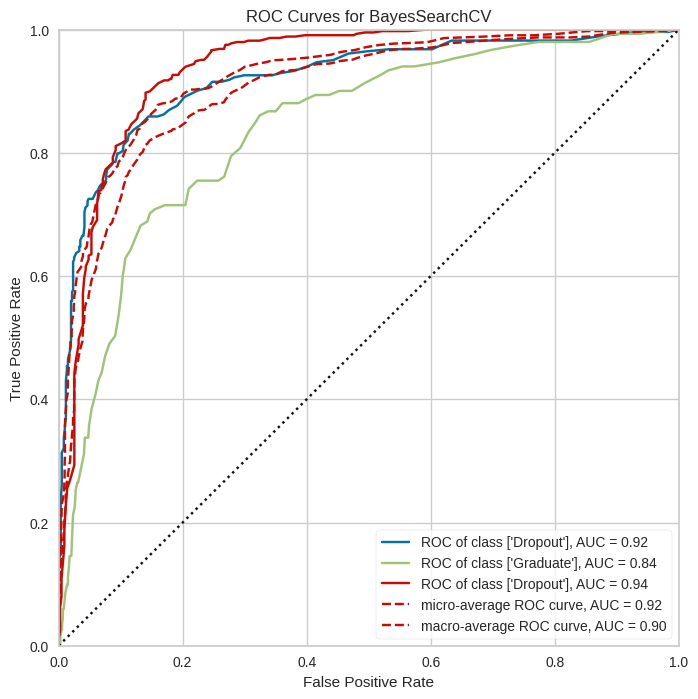

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=        Target
0      Dropout
1     Graduate
2      Dropout
3     Graduate
4     Graduate
...        ...
4419  Graduate
4420   Dropout
4421   Dropout
4422  Graduate
4423  Graduate

[4424 rows x 1 columns],
       estimator=BayesSearchCV(cv=5,
                               estimator=RandomForestClassifier(random_state=0),
                               n_iter=40, n_jobs=-1, random_state=0,
                               search_spaces={'criterion': ['gini', 'entropy'],
                                              'max_depth': [None, 1, 20],
                                              'min_samples_leaf': [1, 20],
                                              'min_samples_split': [2, 20],
                                              'n_estimators': [10, 200]}))

In [ ]:
# AUC
plt.figure(figsize=(8,8))
roc_auc(rf_bs, VarsTestSTD,yTest, classes=target)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


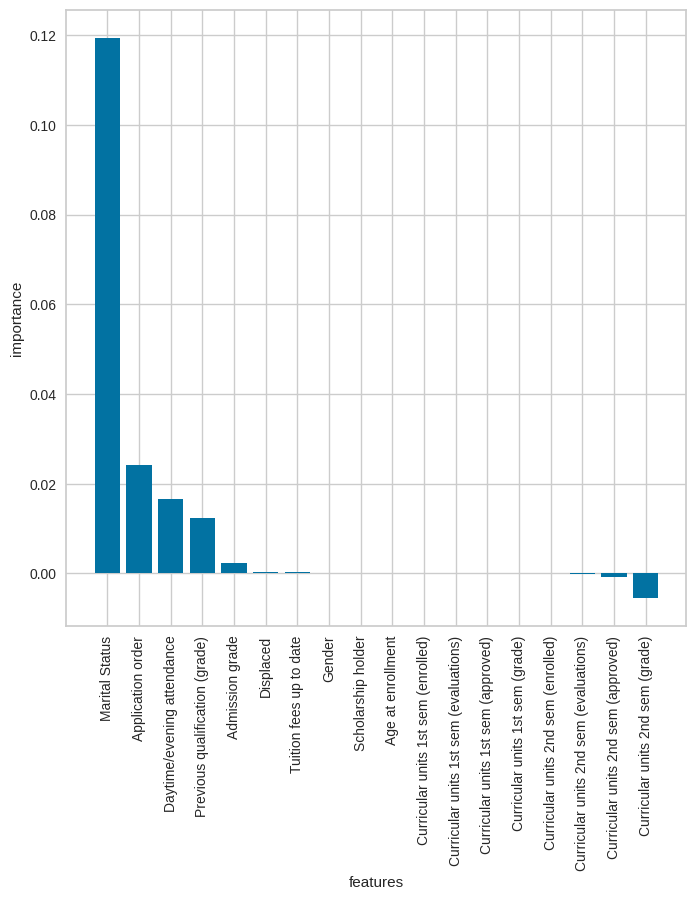

In [ ]:
from sklearn.inspection import permutation_importance

permutations = permutation_importance(rf_bs, VarTest, yTest, n_repeats=15, random_state=1, n_jobs=-1)
feature_names = VarTest.columns
imp = np.sort(permutations['importances_mean'])[::-1]

plt.figure(figsize=(8,8));
plt.bar(feature_names, imp);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

### SVM con kernel RBF

In [ ]:
from sklearn.svm import SVC

params = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

modelSVM =  SVC(kernel='rbf', max_iter=25000, random_state=0)
modelSVM_bs = BayesSearchCV(
    modelSVM,
    params,
    n_iter=40,
    cv=5,
    n_jobs=-1,
    refit=True,
    random_state=0
)

# ~3 minutos
modelSVM_bs.fit(VarsTrainSTD, yTrain);

# Mejores parámetros encontrados con BayesSearch
print('Mejores hiperparámetros:')
print(modelSVM_bs.best_params_)

Mejores hiperparámetros:
OrderedDict([('C', 1.7378008287493745), ('gamma', 'scale')])


In [ ]:
# ~22 minutos
yPred_SVM_bs = modelSVM_bs.predict(VarsTestSTD)
results_df = save_results(modelSVM_bs, VarsTrainSTD, yTrain, VarsTestSTD, yTest, 'SVM con RBF', results_df)

In [ ]:
accuracy_SVM_bs = accuracy_score(yTest, yPred_SVM_bs)
print(f'Precisión del modelo SVM_RBF con búsqueda bayesiana: {accuracy_SVM_bs}')

Precisión del modelo SVM_RBF con búsqueda bayesiana: 0.7728813559322034


In [ ]:
# Classification Report
class_report_SVM_bs = classification_report(yTest, yPred_SVM_bs, target_names=['dropout', 'enrolled', 'graduate'])
print('Informe de Clasificación SVM_RBF con búsqueda bayesiana:')
print(class_report_SVM_bs)

Informe de Clasificación SVM_RBF con búsqueda bayesiana:
              precision    recall  f1-score   support

     dropout       0.84      0.71      0.77       284
    enrolled       0.50      0.41      0.45       151
    graduate       0.81      0.93      0.87       450

    accuracy                           0.77       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.76      0.77      0.76       885



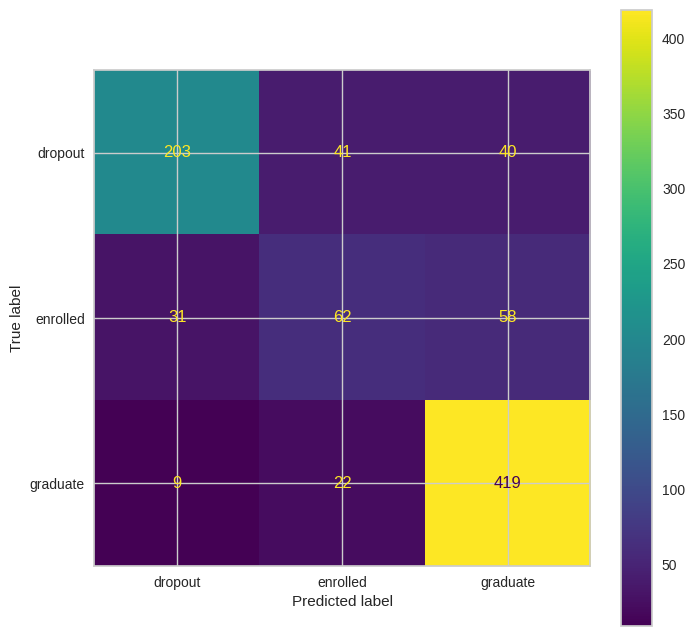

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(modelSVM_bs, VarsTestSTD,yTest, display_labels=['dropout', 'enrolled', 'graduate'], ax=plt.subplot())

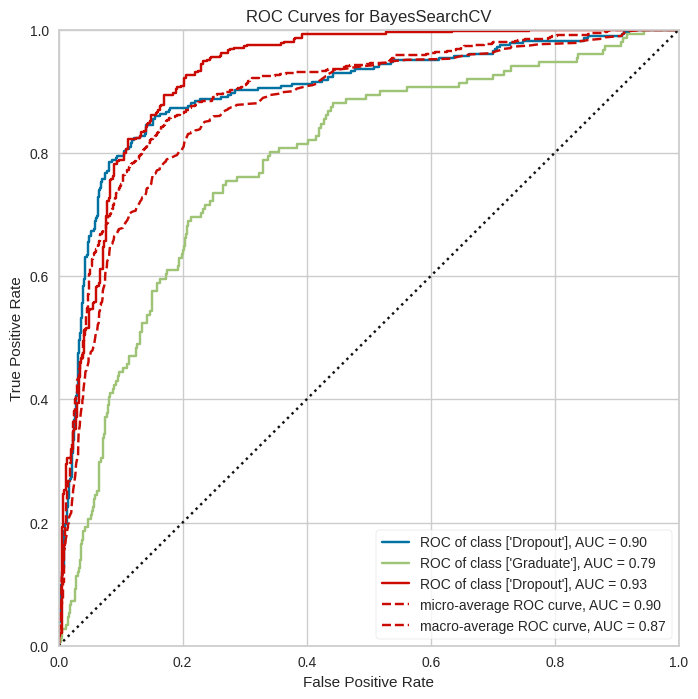

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=        Target
0      Dropout
1     Graduate
2      Dropout
3     Graduate
4     Graduate
...        ...
4419  Graduate
4420   Dropout
4421   Dropout
4422  Graduate
4423  Graduate

[4424 rows x 1 columns],
       estimator=BayesSearchCV(cv=5,
                               estimator=SVC(max_iter=25000, random_state=0),
                               n_iter=40, n_jobs=-1,...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                                              'gamma': ['scale', 'auto']}))

In [ ]:
# AUC
plt.figure(figsize=(8,8))
roc_auc(modelSVM_bs, VarsTestSTD,yTest, classes=target)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': [5, 200],
         'loss':['log_loss'],       # No se puede hacer con la función 'exponential' porque tenemos 3 clases objetivos y ésta solo admite 2
         'criterion':['friedman_mse', 'squared_error'],
         'max_depth':[None, 1, 20],
         'min_samples_leaf':[1, 15],
         'learning_rate':[0.01, 15]}

# Ajustamos el modelo con Búsqueda Bayesiana
model_GB =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
model_GB_bs = BayesSearchCV(
    model_GB,
    params,
    n_iter = 40,
    cv = 5,
    n_jobs=-1,
    refit=True,
    random_state=0
)

# ~14 minutos
model_GB_bs.fit(VarsTrainSTD, yTrain);

# Mejores parámetros encontrados con BayesSearch
print('Mejores hiperparámetros:')
print(model_GB_bs.best_params_)

Mejores hiperparámetros:
OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.01), ('loss', 'log_loss'), ('max_depth', None), ('min_samples_leaf', 15), ('n_estimators', 191)])


In [ ]:
# ~1h 17 minutos
yPred_GB_bs = model_GB_bs.predict(VarsTestSTD)
results_df = save_results(model_GB_bs, VarsTrainSTD, yTrain, VarsTestSTD, yTest, 'Gradient Boosting', results_df)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [ ]:
accuracy_GB_bs = accuracy_score(yTest, yPred_GB_bs)
print(f'Precisión del modelo Gradient Boosting con búsqueda bayesiana: {accuracy_GB_bs}')

Precisión del modelo Gradient Boosting con búsqueda bayesiana: 0.7875706214689265


In [ ]:
# Classification Report
class_report_GB_bs = classification_report(yTest, yPred_GB_bs, target_names=['dropout', 'enrolled', 'graduate'])
print('Informe de Clasificación Gradient Boosting con búsqueda bayesiana:')
print(class_report_GB_bs)

Informe de Clasificación Gradient Boosting con búsqueda bayesiana:
              precision    recall  f1-score   support

     dropout       0.79      0.75      0.77       284
    enrolled       0.58      0.39      0.47       151
    graduate       0.82      0.94      0.88       450

    accuracy                           0.79       885
   macro avg       0.73      0.70      0.71       885
weighted avg       0.77      0.79      0.77       885



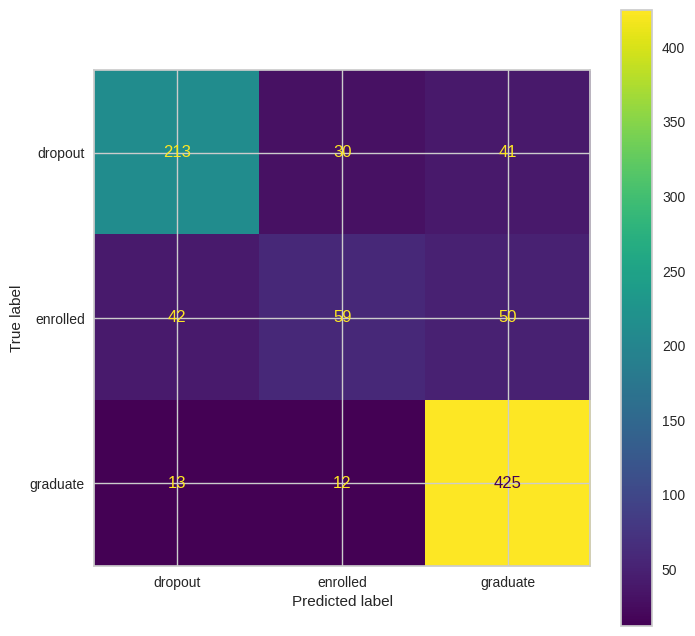

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(model_GB_bs, VarsTestSTD,yTest, display_labels=['dropout', 'enrolled', 'graduate'], ax=plt.subplot())

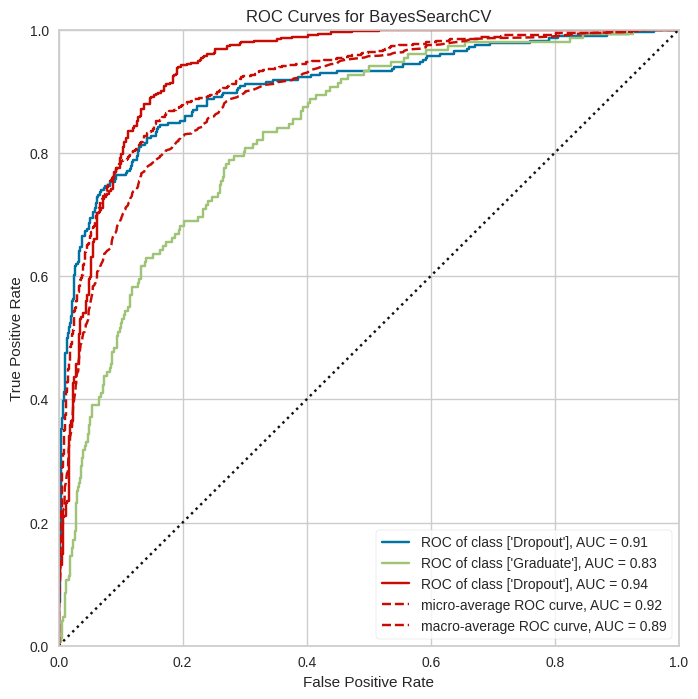

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=        Target
0      Dropout
1     Graduate
2      Dropout
3     Graduate
4     Graduate
...        ...
4419  Graduate
4420   Dropout
4421   Dropout
4422  Graduate
4423  Graduate

[4424 rows x 1 columns],
       estimator=BayesSearchCV(cv=5,
                               estimator=GradientBoostingClassifier(n_iter_no_change=5,
                                                                    random_state=0),
                               n_iter=40, n_jobs=-1, random_state=0,
                               search_spaces={'criterion': ['friedman_mse',
                                                            'squared_error'],
                                              'learning_rate': [0.01, 15],
                                              'loss': ['log_loss'],
                                              'max_depth': [None, 1, 20],
                                              'min_samples_leaf': [1, 15],
                                              'n_estimators': [5, 200]}))

In [ ]:
# AUC
plt.figure(figsize=(8,8))
roc_auc(model_GB_bs, VarsTestSTD,yTest, classes=target)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


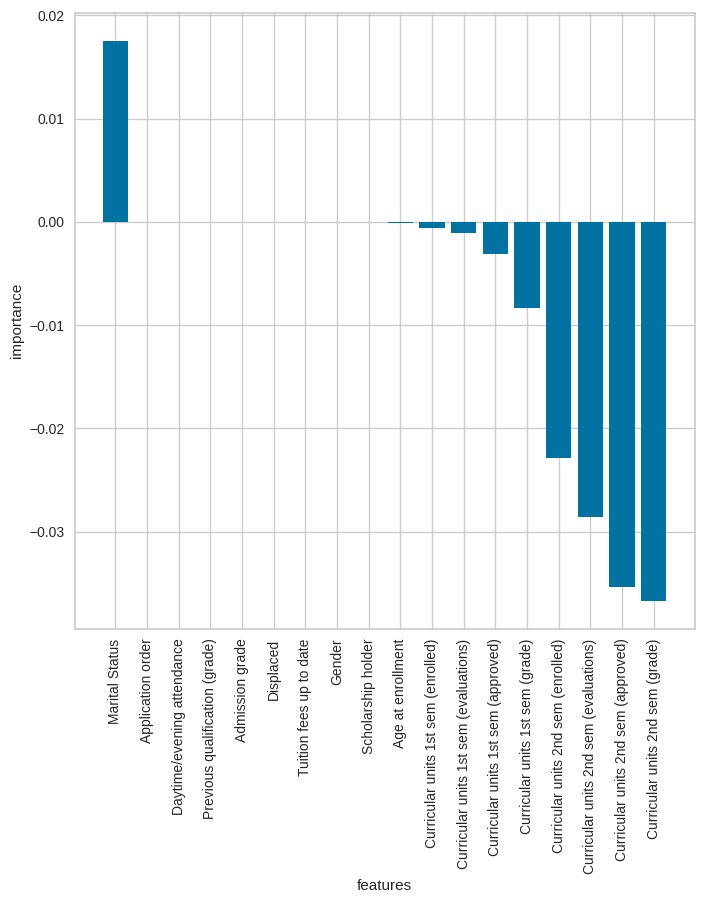

In [ ]:
permutations = permutation_importance(model_GB_bs, VarTest, yTest, n_repeats=15, random_state=1, n_jobs=-1)
feature_names = VarTest.columns
imp = np.sort(permutations['importances_mean'])[::-1]

plt.figure(figsize=(8,8));
plt.bar(feature_names, imp);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

## Resultados

In [ ]:
results_df.sort_values(by=['test acc'], ascending= False)

,train acc,test acc,precision score (W),recall score (W),f1 score (W)
Random Forest,0.757269,0.795480,0.785547,0.795480,0.786760
Gradient Boosting,0.755295,0.787571,0.773519,0.787571,0.774964
Logistic Regression,0.757558,0.777401,0.763025,0.777401,0.765572
SVM con RBF,0.747957,0.772881,0.764799,0.772881,0.764523
LDA,0.749925,0.767232,0.763241,0.767232,0.755793
Naive Bayes,0.717989,0.727684,0.712841,0.727684,0.716667


## Ejemplos concretos

In [ ]:
df = pd.DataFrame(VarsTrainSTD)

# Regresión logística
minMarital = df[df[0] == df[0].min()]
print(lr_gs.predict(minMarital.head()))

maxSecCurricular = df[df[16] == df[16].max()]
print(lr_gs.predict(maxSecCurricular.head()))

# Random Forest
minMarital = df[df[0] == df[0].min()]
print(rf_bs.predict(minMarital.head()))

maxSecCurricular = df[df[16] == df[16].max()]
print(rf_bs.predict(maxSecCurricular.head()))

[2 2 2 2 2]
[2]
[2 1 2 2 2]
[2]
